<a href="https://colab.research.google.com/github/ericmach/DX703_Advanced_Machine_Learning/blob/main/Homework_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework.


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [6]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


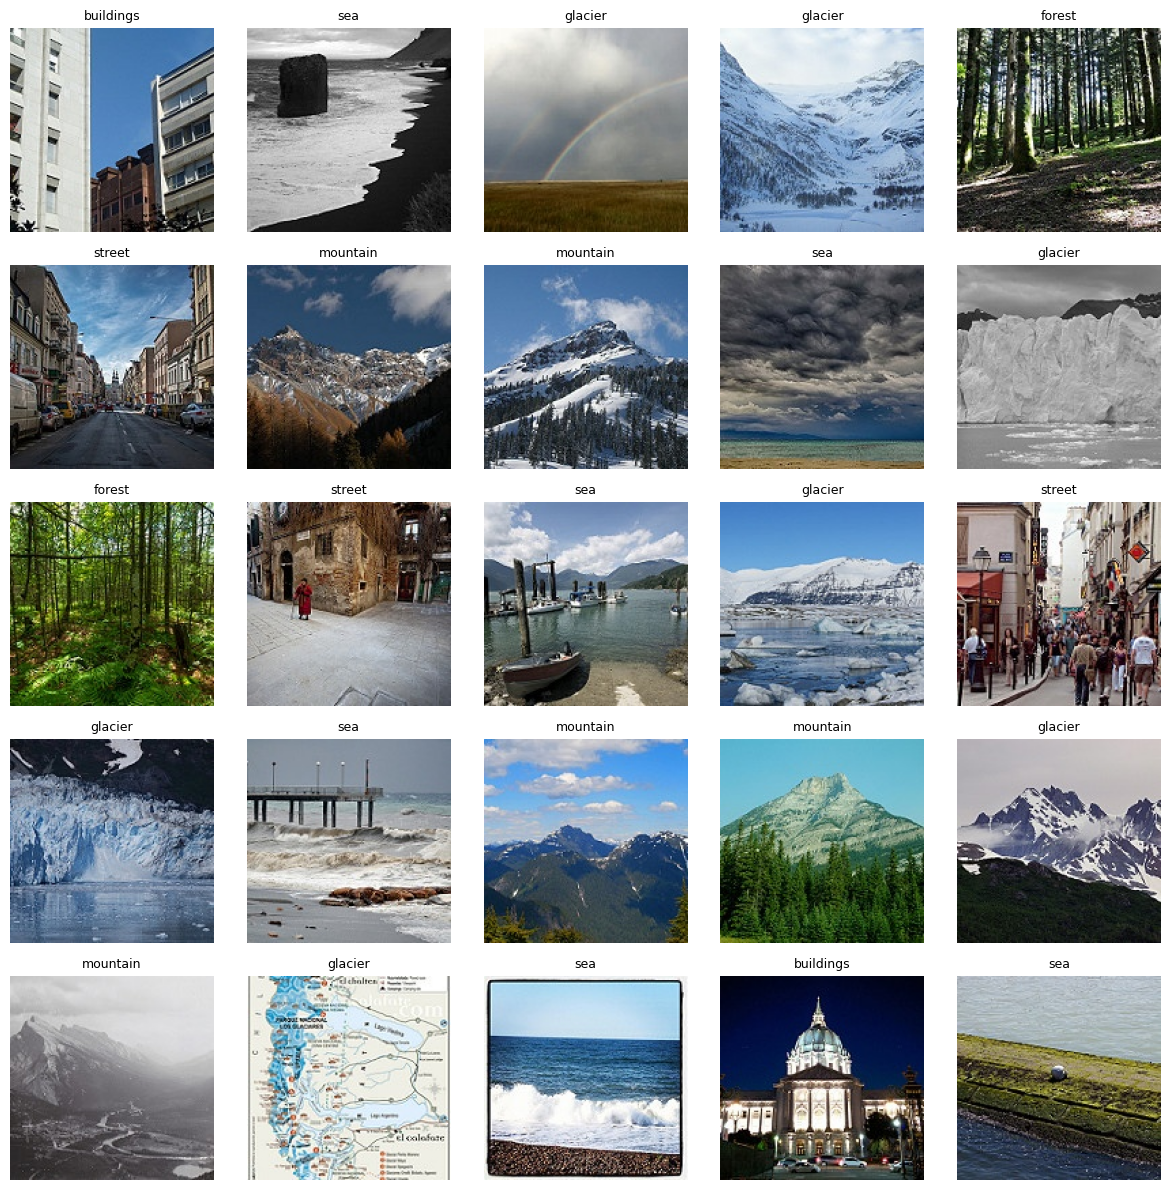

In [7]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.



Baseline Model



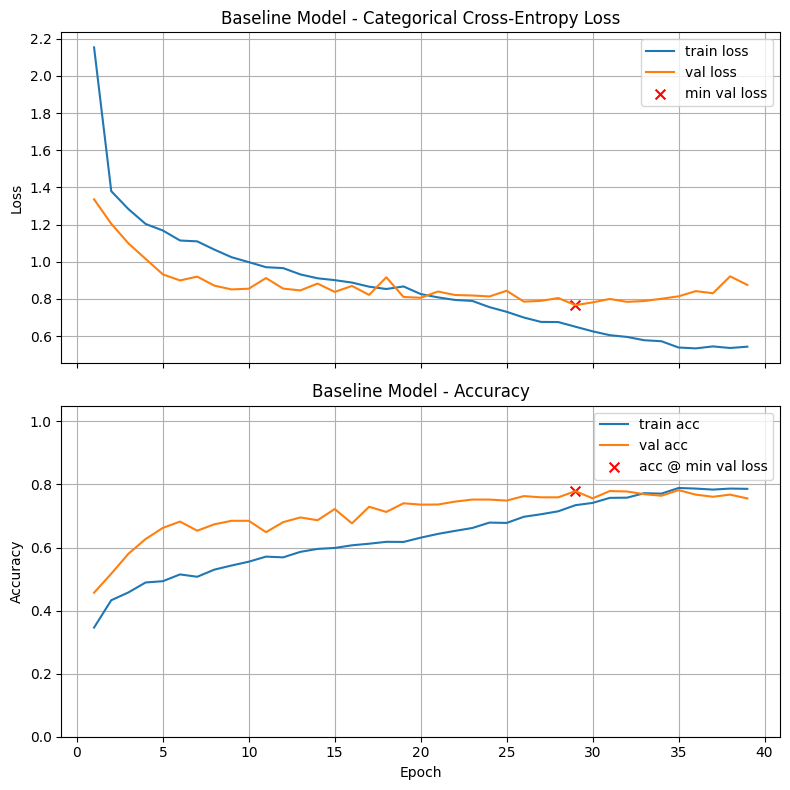

Final Training Loss:            0.5430
Final Training Accuracy:        0.7861
Final Validation Loss:          0.8753
Final Validation Accuracy:      0.7556
Minimum Validation Loss:        0.7665 (Epoch 29)
Validation Accuracy @ Min Loss: 0.7788

Test Loss: 0.7567
Test Accuracy: 0.7680

Validation-Test Gap (accuracy): 0.010767

Execution Time: 00:01:45


In [8]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1 -- Tweak 1 -- lr: 0.0005



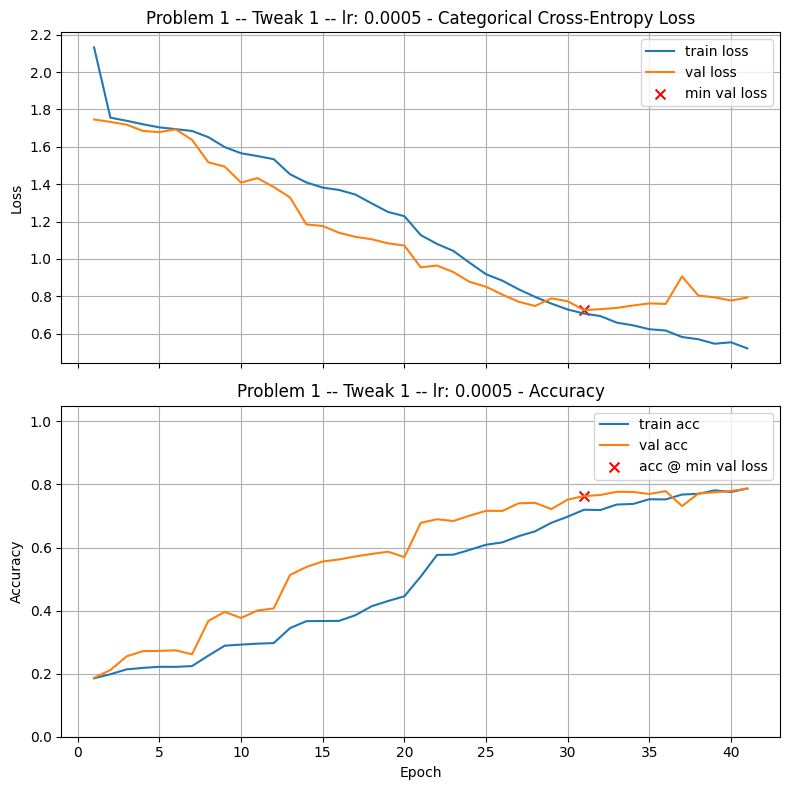

Final Training Loss:            0.5212
Final Training Accuracy:        0.7871
Final Validation Loss:          0.7934
Final Validation Accuracy:      0.7866
Minimum Validation Loss:        0.7258 (Epoch 31)
Validation Accuracy @ Min Loss: 0.7631

Test Loss: 0.7221
Test Accuracy: 0.7560

Validation-Test Gap (accuracy): 0.007092

Execution Time: 00:01:38


In [9]:
# Your code here, add additional cells if you wish

model_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr, title="Problem 1 -- Tweak 1 -- lr: 0.0005", lr_schedule=5e-4)


Problem 1 -- Tweak 2 -- wider conv: 64→128



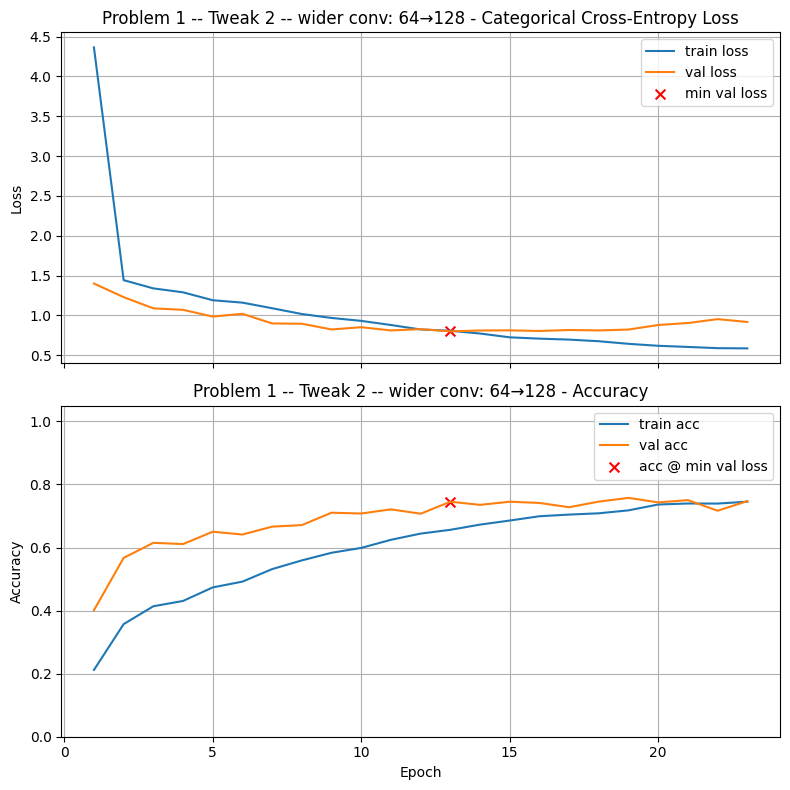

Final Training Loss:            0.5871
Final Training Accuracy:        0.7453
Final Validation Loss:          0.9185
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.8005 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7453

Test Loss: 0.7823
Test Accuracy: 0.7480

Validation-Test Gap (accuracy): 0.002720

Execution Time: 00:01:30


In [10]:
model_wide = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_wide, title="Problem 1 -- Tweak 2 -- wider conv: 64→128")


Problem 1 -- Tweak 3 -- dropout: 0.2



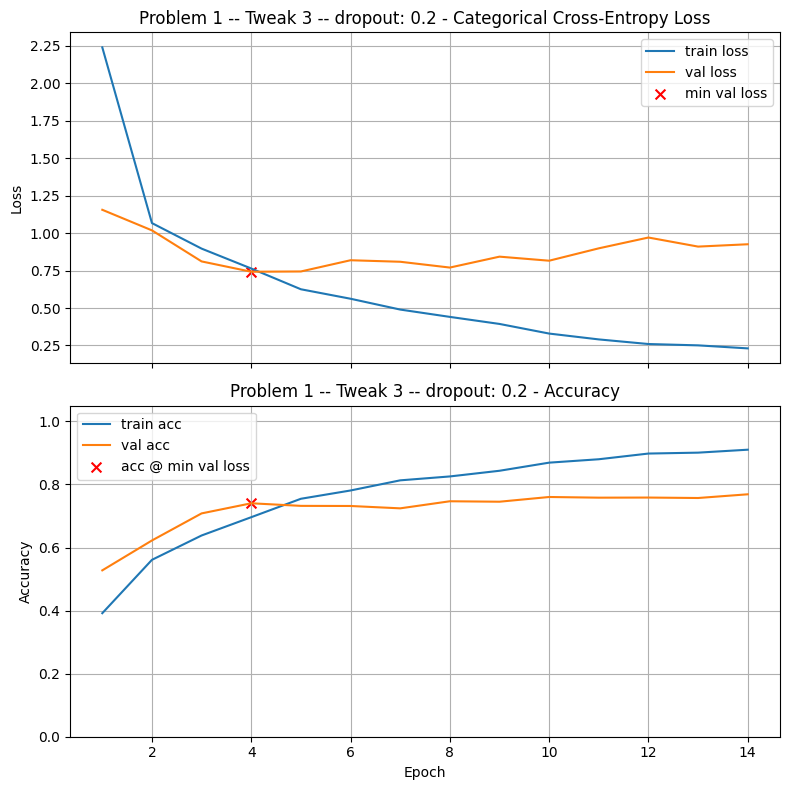

Final Training Loss:            0.2307
Final Training Accuracy:        0.9102
Final Validation Loss:          0.9252
Final Validation Accuracy:      0.7688
Minimum Validation Loss:        0.7419 (Epoch 4)
Validation Accuracy @ Min Loss: 0.7403

Test Loss: 0.7570
Test Accuracy: 0.7320

Validation-Test Gap (accuracy): 0.008292

Execution Time: 00:00:41


In [11]:
model_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dropout, title="Problem 1 -- Tweak 3 -- dropout: 0.2")

In [12]:
print_results()

Baseline Model                          	0.7788	29
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7631	31
Problem 1 -- Tweak 2 -- wider conv: 64→128	0.7453	13
Problem 1 -- Tweak 3 -- dropout: 0.2    	0.7403	4


### Graded Questions

In [13]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [14]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 1


In [15]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.7631             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7631


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 2 -- BN after Conv -- lr: 0.0005



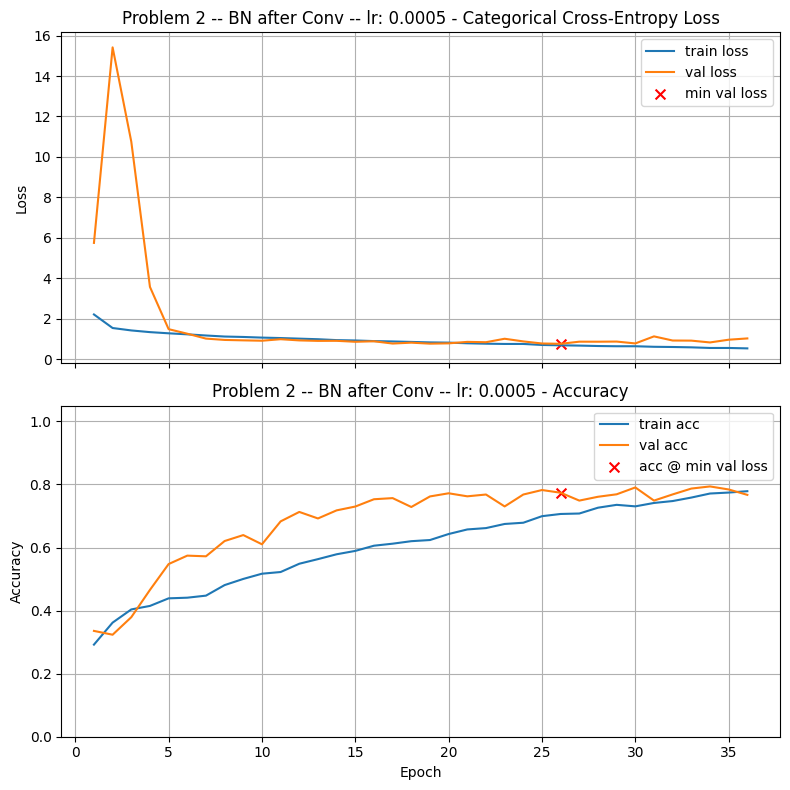

Final Training Loss:            0.5308
Final Training Accuracy:        0.7787
Final Validation Loss:          1.0230
Final Validation Accuracy:      0.7670
Minimum Validation Loss:        0.7575 (Epoch 26)
Validation Accuracy @ Min Loss: 0.7738

Test Loss: 0.7359
Test Accuracy: 0.7923

Validation-Test Gap (accuracy): 0.018553

Execution Time: 00:01:37


In [17]:
# Your code here, add additional cells if you wish

model_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn, title="Problem 2 -- BN after Conv -- lr: 0.0005", lr_schedule=5e-4)


Problem 2 -- BN + dropout 0.2 -- lr: 0.0005



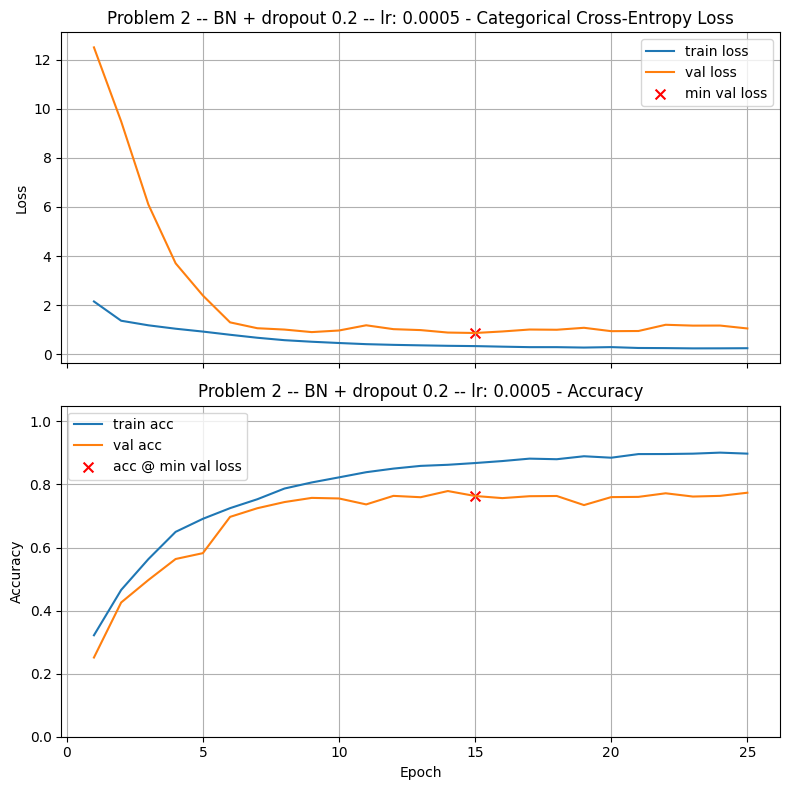

Final Training Loss:            0.2501
Final Training Accuracy:        0.8977
Final Validation Loss:          1.0541
Final Validation Accuracy:      0.7738
Minimum Validation Loss:        0.8698 (Epoch 15)
Validation Accuracy @ Min Loss: 0.7634

Test Loss: 0.8326
Test Accuracy: 0.7747

Validation-Test Gap (accuracy): 0.011218

Execution Time: 00:01:11


In [18]:
model_bn_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn_dropout, title="Problem 2 -- BN + dropout 0.2 -- lr: 0.0005", lr_schedule=5e-4)

In [19]:
print_results()

Baseline Model                          	0.7788	29
Problem 2 -- BN after Conv -- lr: 0.0005	0.7738	26
Problem 2 -- BN + dropout 0.2 -- lr: 0.0005	0.7634	15
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7631	31
Problem 1 -- Tweak 2 -- wider conv: 64→128	0.7453	13
Problem 1 -- Tweak 3 -- dropout: 0.2    	0.7403	4


### Graded Questions

In [20]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 1


In [22]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.7738             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7738


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 3 -- BN + GAP -- lr: 0.0005



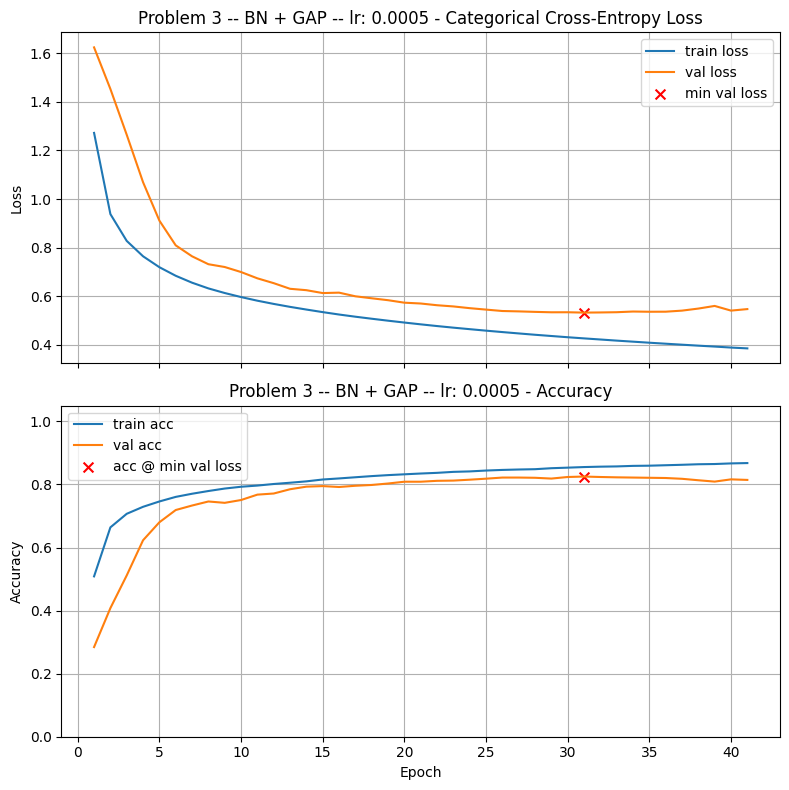

Final Training Loss:            0.3856
Final Training Accuracy:        0.8678
Final Validation Loss:          0.5473
Final Validation Accuracy:      0.8144
Minimum Validation Loss:        0.5328 (Epoch 31)
Validation Accuracy @ Min Loss: 0.8251

Test Loss: 0.5138
Test Accuracy: 0.8237

Validation-Test Gap (accuracy): 0.001413

Execution Time: 00:01:49


In [24]:
# Your code here, add additional cells if you wish
model_gap = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap, title="Problem 3 -- BN + GAP -- lr: 0.0005", lr_schedule=5e-4)



Problem 3 -- BN + GAP + wider conv (64→128) -- lr: 0.0005



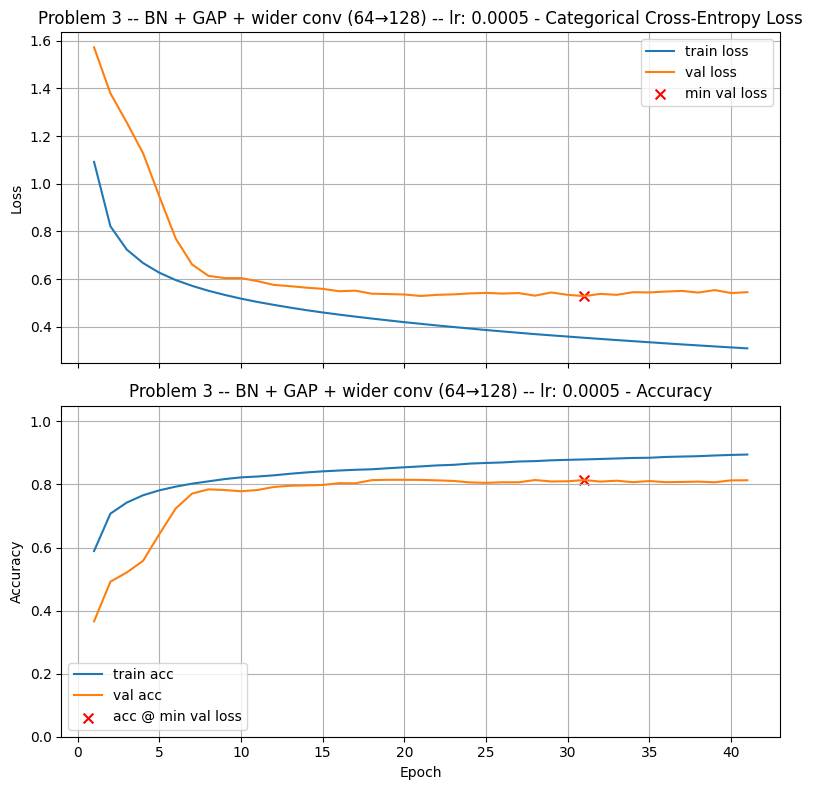

Final Training Loss:            0.3090
Final Training Accuracy:        0.8949
Final Validation Loss:          0.5449
Final Validation Accuracy:      0.8133
Minimum Validation Loss:        0.5285 (Epoch 31)
Validation Accuracy @ Min Loss: 0.8140

Test Loss: 0.5132
Test Accuracy: 0.8147

Validation-Test Gap (accuracy): 0.000630

Execution Time: 00:02:35


In [25]:
model_gap_wide = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_wide, title="Problem 3 -- BN + GAP + wider conv (64→128) -- lr: 0.0005", lr_schedule=5e-4)

In [26]:
print_results()

Problem 3 -- BN + GAP -- lr: 0.0005     	0.8251	31
Problem 3 -- BN + GAP + wider conv (64→128) -- lr: 0.0005	0.8140	31
Baseline Model                          	0.7788	29
Problem 2 -- BN after Conv -- lr: 0.0005	0.7738	26
Problem 2 -- BN + dropout 0.2 -- lr: 0.0005	0.7634	15
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7631	31
Problem 1 -- Tweak 2 -- wider conv: 64→128	0.7453	13
Problem 1 -- Tweak 3 -- dropout: 0.2    	0.7403	4


### Graded Questions

In [27]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [28]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 1


In [29]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8251             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8251


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.



In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed


Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=3)



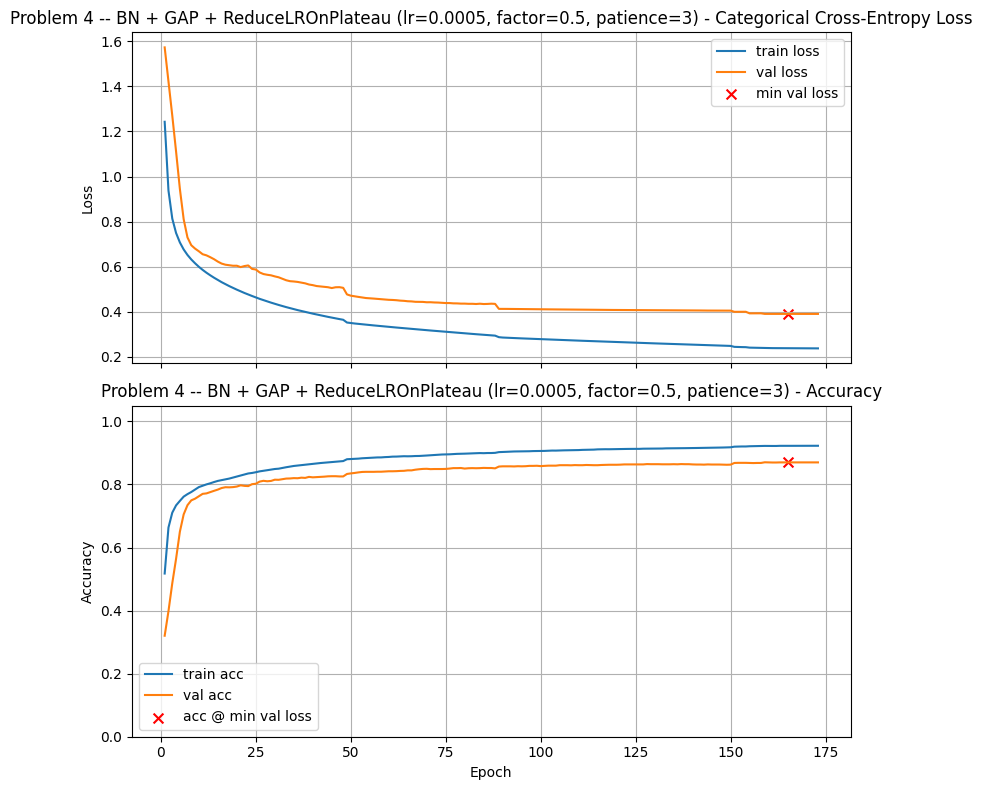

Final Training Loss:            0.2381
Final Training Accuracy:        0.9227
Final Validation Loss:          0.3910
Final Validation Accuracy:      0.8700
Minimum Validation Loss:        0.3909 (Epoch 165)
Validation Accuracy @ Min Loss: 0.8700

Test Loss: 0.3677
Test Accuracy: 0.8707

Validation-Test Gap (accuracy): 0.000699

Execution Time: 00:06:40


In [32]:
model_gap_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(
    model_gap_bn,
    title="Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=3)",
    lr_schedule=5e-4,
    callbacks=[reduce_lr]
)

In [33]:
reduce_lr2 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)


Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.3, patience=3)



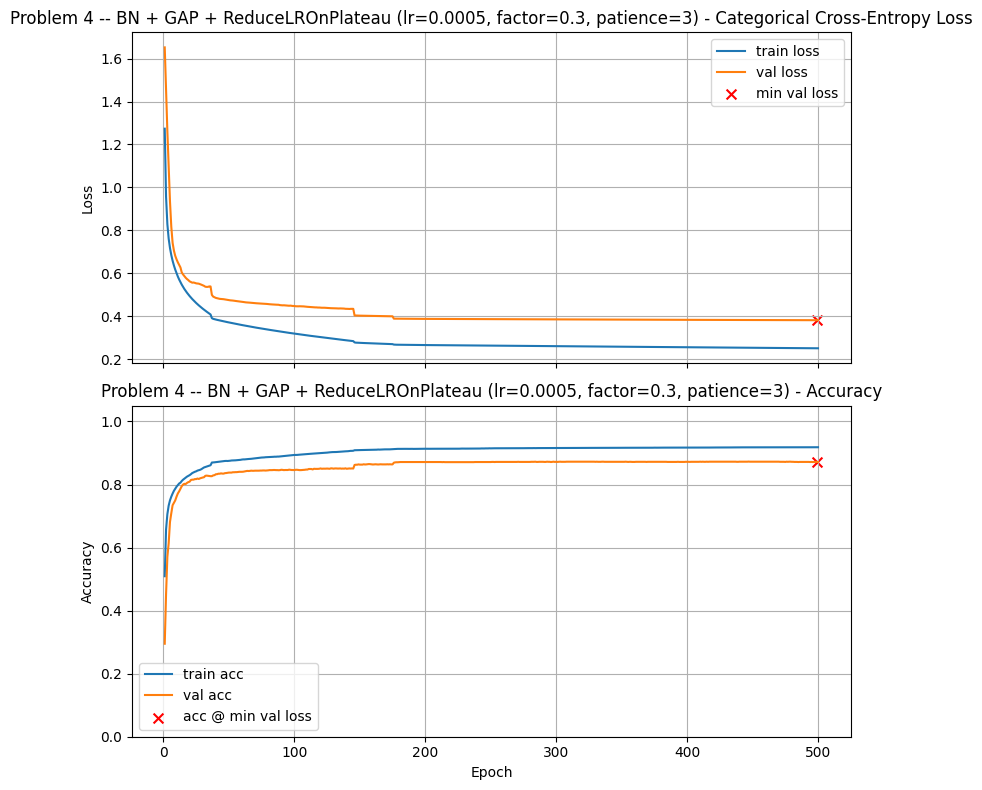

Final Training Loss:            0.2512
Final Training Accuracy:        0.9183
Final Validation Loss:          0.3819
Final Validation Accuracy:      0.8714
Minimum Validation Loss:        0.3818 (Epoch 499)
Validation Accuracy @ Min Loss: 0.8717

Test Loss: 0.4015
Test Accuracy: 0.8750

Validation-Test Gap (accuracy): 0.003251

Execution Time: 00:18:50


In [34]:
model_gap_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(
    model_gap_bn,
    title="Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.3, patience=3)",
    lr_schedule=5e-4,
    callbacks=[reduce_lr2]
)

In [35]:
reduce_lr3 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)


Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=5)



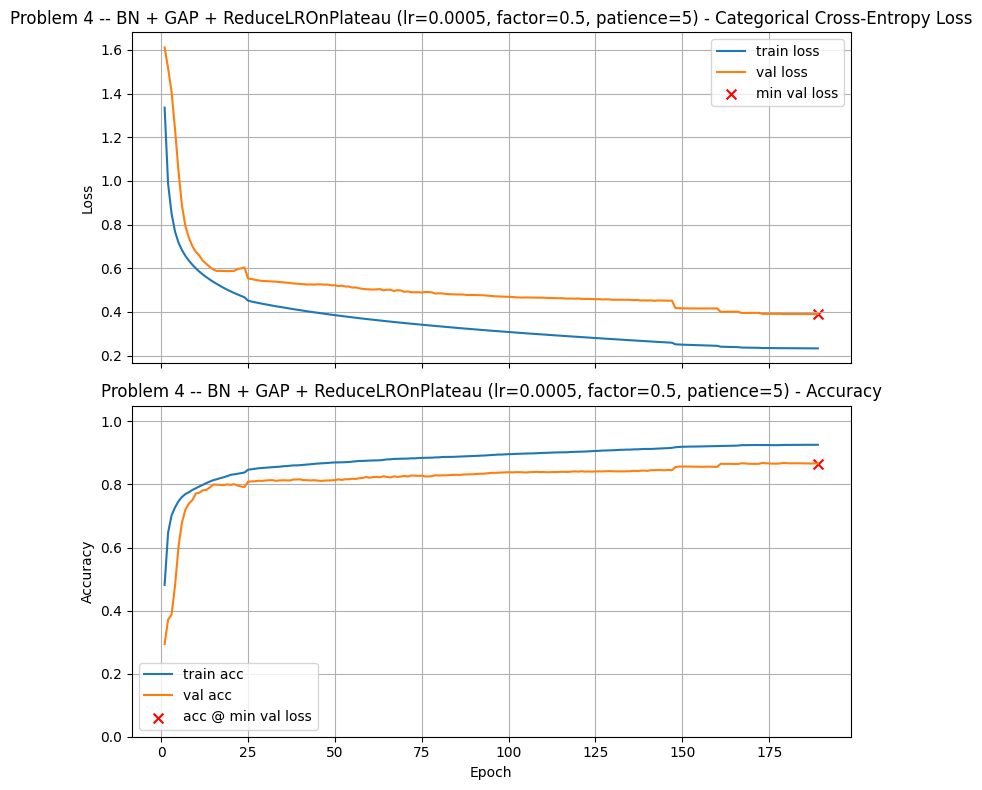

Final Training Loss:            0.2329
Final Training Accuracy:        0.9257
Final Validation Loss:          0.3902
Final Validation Accuracy:      0.8664
Minimum Validation Loss:        0.3902 (Epoch 189)
Validation Accuracy @ Min Loss: 0.8664

Test Loss: 0.4005
Test Accuracy: 0.8660

Validation-Test Gap (accuracy): 0.002187

Execution Time: 00:07:15


In [36]:
model_gap_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(
    model_gap_bn,
    title="Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=5)",
    lr_schedule=5e-4,
    callbacks=[reduce_lr3]
)

In [37]:
print_results()

Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.3, patience=3)	0.8717	499
Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=3)	0.8700	165
Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=5)	0.8664	189
Problem 3 -- BN + GAP -- lr: 0.0005     	0.8251	31
Problem 3 -- BN + GAP + wider conv (64→128) -- lr: 0.0005	0.8140	31
Baseline Model                          	0.7788	29
Problem 2 -- BN after Conv -- lr: 0.0005	0.7738	26
Problem 2 -- BN + dropout 0.2 -- lr: 0.0005	0.7634	15
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7631	31
Problem 1 -- Tweak 2 -- wider conv: 64→128	0.7453	13
Problem 1 -- Tweak 3 -- dropout: 0.2    	0.7403	4


### Graded Questions

In [38]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.3             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [39]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.30


In [40]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8717             # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8717


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




Problem 5: VGG-style Large



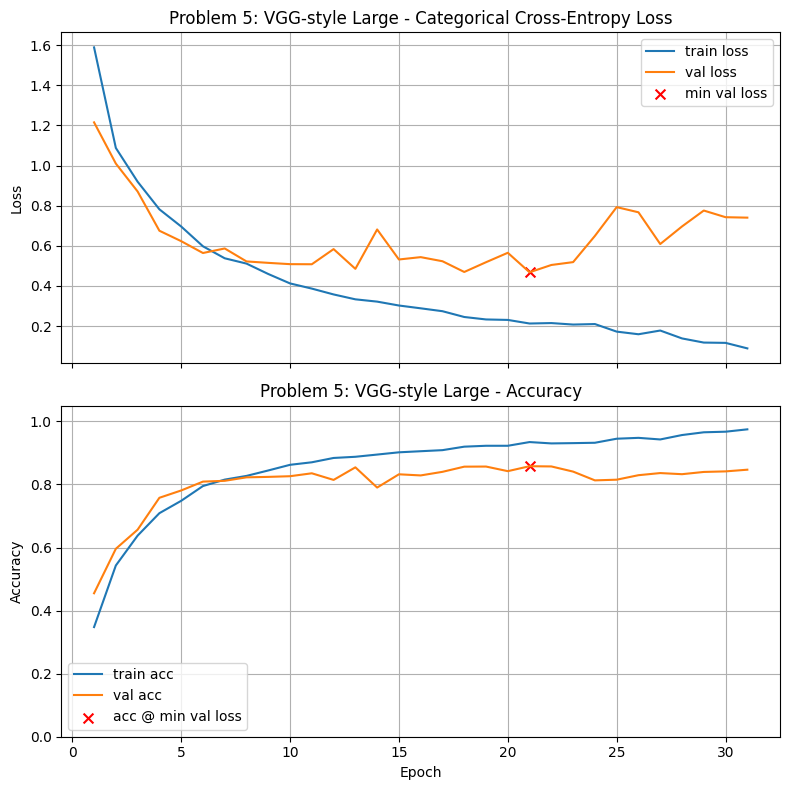

Final Training Loss:            0.0886
Final Training Accuracy:        0.9748
Final Validation Loss:          0.7404
Final Validation Accuracy:      0.8468
Minimum Validation Loss:        0.4680 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8579

Test Loss: 0.4511
Test Accuracy: 0.8560

Validation-Test Gap (accuracy): 0.001855

Execution Time: 00:05:42


In [42]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="Problem 5: VGG-style Large")



Problem 5: VGG-style Large -- lr = 1e-4



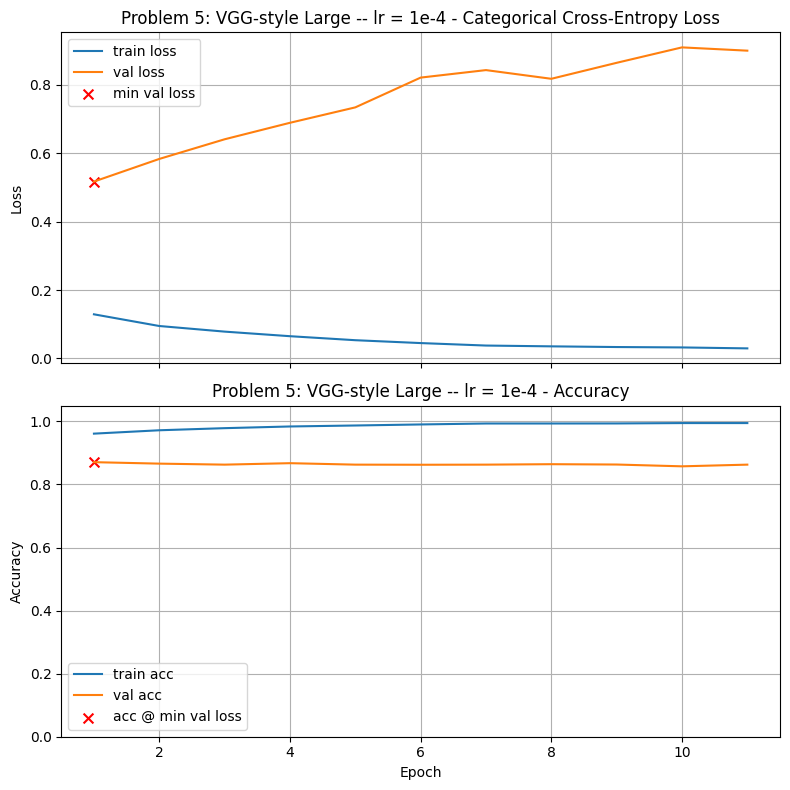

Final Training Loss:            0.0295
Final Training Accuracy:        0.9947
Final Validation Loss:          0.9000
Final Validation Accuracy:      0.8628
Minimum Validation Loss:        0.5173 (Epoch 1)
Validation Accuracy @ Min Loss: 0.8707

Test Loss: 0.4769
Test Accuracy: 0.8780

Validation-Test Gap (accuracy): 0.007320

Execution Time: 00:01:56


In [43]:
train_and_test(model_vgg_16,lr_schedule=1e-4,title="Problem 5: VGG-style Large -- lr = 1e-4")


Problem 5: VGG-style Large -- lr = 1e-5



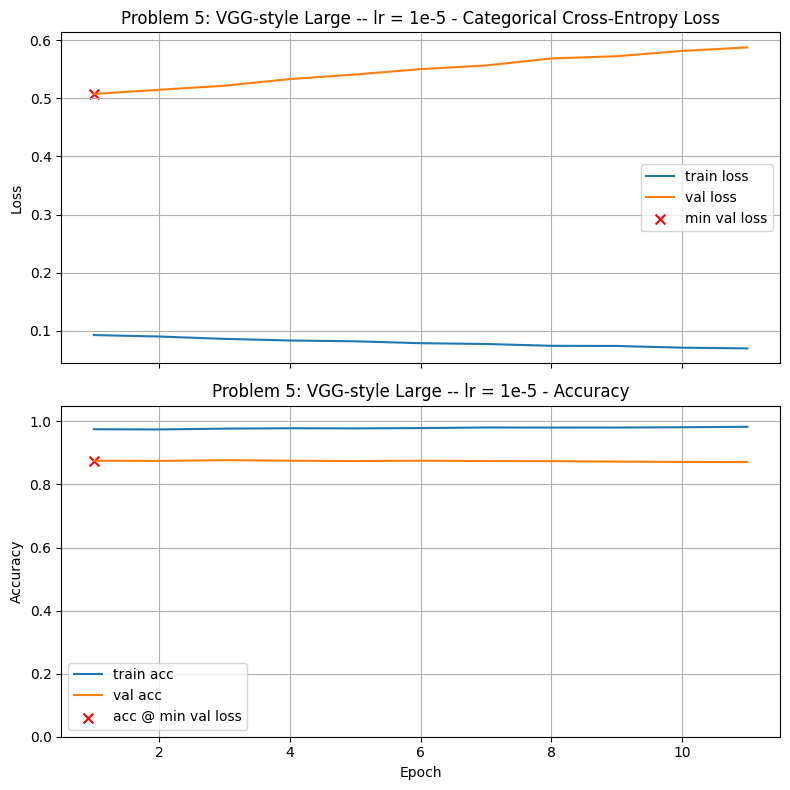

Final Training Loss:            0.0694
Final Training Accuracy:        0.9829
Final Validation Loss:          0.5879
Final Validation Accuracy:      0.8710
Minimum Validation Loss:        0.5077 (Epoch 1)
Validation Accuracy @ Min Loss: 0.8753

Test Loss: 0.4743
Test Accuracy: 0.8823

Validation-Test Gap (accuracy): 0.007022

Execution Time: 00:01:56


In [44]:
train_and_test(model_vgg_16,lr_schedule=1e-5,title="Problem 5: VGG-style Large -- lr = 1e-5")


Problem 5: VGG-style Large -- lr = 1e-2



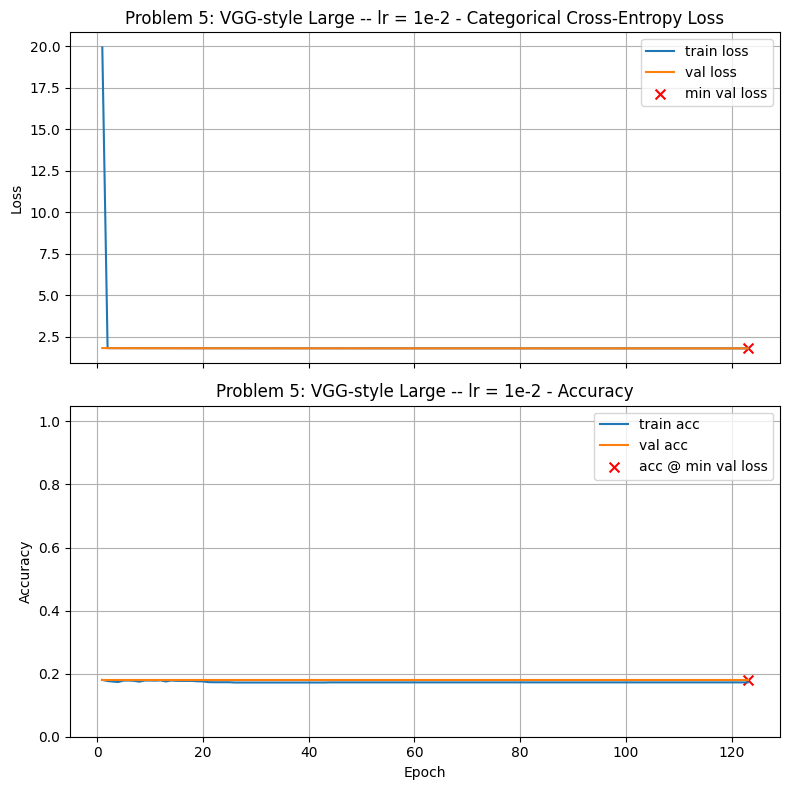

Final Training Loss:            1.7915
Final Training Accuracy:        0.1724
Final Validation Loss:          1.7908
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.7908 (Epoch 123)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.7907
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:17:49


In [45]:
train_and_test(model_vgg_16,lr_schedule=1e-2,title="Problem 5: VGG-style Large -- lr = 1e-2")

### Graded Questions

In [46]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 1e-5             # Replace with your best learning rate

In [47]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00001000


In [48]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8753              # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8753


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [50]:
print_results()

Problem 5: VGG-style Large -- lr = 1e-5 	0.8753	1
Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.3, patience=3)	0.8717	499
Problem 5: VGG-style Large -- lr = 1e-4 	0.8707	1
Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=3)	0.8700	165
Problem 4 -- BN + GAP + ReduceLROnPlateau (lr=0.0005, factor=0.5, patience=5)	0.8664	189
Problem 5: VGG-style Large              	0.8579	21
Problem 3 -- BN + GAP -- lr: 0.0005     	0.8251	31
Problem 3 -- BN + GAP + wider conv (64→128) -- lr: 0.0005	0.8140	31
Baseline Model                          	0.7788	29
Problem 2 -- BN after Conv -- lr: 0.0005	0.7738	26
Problem 2 -- BN + dropout 0.2 -- lr: 0.0005	0.7634	15
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7631	31
Problem 1 -- Tweak 2 -- wider conv: 64→128	0.7453	13
Problem 1 -- Tweak 3 -- dropout: 0.2    	0.7403	4
Problem 5: VGG-style Large -- lr = 1e-2 	0.1792	123
